# PD3: Power Plant Machine Learning Pipeline Application
## MTI850 - Big Data Analytics
### Fall 2021

<br>
<br>    
    
| Equipe | 1                                   |
|----------|---------------------------------------------------------|

<br>
<br>

![Spark Logo](https://github.com/alekoe/alekoe.github.io/blob/master/images/ta_Spark-logo-small.png?raw=true) ![Python Logo](https://github.com/alekoe/alekoe.github.io/blob/master/images/python-logo-master-v3-TM-flattened_small.png?raw=true)

**Background**

Power generation is a complex process, and understanding and predicting power output is an important element in managing a plant and its connection to the power grid. The operators of a regional power grid create predictions of power demand based on historical information and environmental factors (e.g., temperature). They then compare the predictions against available resources (e.g., coal, natural gas, nuclear, solar, wind, hydro power plants).

Power generation technologies such as solar and wind are highly dependent on environmental conditions, and all generation technologies are subject to planned and unplanned maintenance. Here is an real-world example of predicted demand (on two time scales), actual demand, and available resources from the California power grid: http://www.caiso.com/Pages/TodaysOutlook.aspx
![](http://content.caiso.com/outlook/SP/ems_small.gif)

The challenge for a power grid operator is how to handle a shortfall in available resources versus actual demand. There are three solutions to  a power shortfall: build more base load power plants (this process can take many years to decades of planning and construction), buy and import power from other regional power grids (this choice can be very expensive and is limited by the power transmission interconnects between grids and the excess power available from other grids), or turn on small [Peaker or Peaking Power Plants](https://en.wikipedia.org/wiki/Peaking_power_plant). Because grid operators need to respond quickly to a power shortfall to avoid a power outage, grid operators rely on a combination of the last two choices. In this exercise, we'll focus on the last choice.

**The Business Problem**

Because they supply power only occasionally, the power supplied by a peaker power plant commands a much higher price per kilowatt hour than power from a power grid's base power plants. A peaker plant may operate many hours a day, or it may operate only a few hours per year, depending on the condition of the region's electrical grid. Because of the cost of building an efficient power plant, if a peaker plant is only going to be run for a short or highly variable time it does not make economic sense to make it as efficient as a base load power plant. In addition, the equipment and fuels used in base load plants are often unsuitable for use in peaker plants because the fluctuating conditions would severely strain the equipment.

The power output of a peaker power plant varies depending on environmental conditions, so the business problem is _predicting the power output of a peaker power plant as a function of the environmental conditions_ -- since this would enable the grid operator to make economic tradeoffs about the number of peaker plants to turn on (or whether to buy expensive power from another grid).

Given this business problem, we need to first perform Exploratory Data Analysis to understand the data and then translate the business problem (predicting power output as a function of envionmental conditions) into a Machine Learning task.  In this instance, the ML task is regression since the label (or target) we are trying to predict is numeric. We will use an [Apache Spark ML Pipeline](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark-ml-package) to perform the regression.

The real-world data we are using in this notebook consists of 9,568 data points, each with 4 environmental attributes collected from a Combined Cycle Power Plant over 6 years (2006-2011), and is provided by the University of California, Irvine at [UCI Machine Learning Repository Combined Cycle Power Plant Data Set](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant). You can find more details about the dataset on the UCI page, including the following background publications:
* Pinar Tüfekci, [Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods](http://www.journals.elsevier.com/international-journal-of-electrical-power-and-energy-systems/), International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615.
* Heysem Kaya, Pinar Tüfekci and Fikret S. Gürgen: [Local and Global Learning Methods for Predicting Power of a Combined Gas & Steam Turbine](http://www.cmpe.boun.edu.tr/~kaya/kaya2012gasturbine.pdf), Proceedings of the International Conference on Emerging Trends in Computer and Electronics Engineering ICETCEE 2012, pp. 13-18 (Mar. 2012, Dubai).

This is an end-to-end assignment of performing on a real-world dataset:
* Extract-Transform-Load (ETL),
* Exploratory data analysis (EDA), and
* Applying machine learning (ML) algorithms

to solve a supervised regression problem on the dataset.

**To Do**: Read the documentation and examples for [Spark Machine Learning Pipeline](https://spark.apache.org/docs/3.0.0/ml-guide.html#main-concepts-in-pipelines).

**This assignment covers:**
* *Part 1: Business Understanding*
* *Part 2: Load Your Data*
* *Part 3: Explore Your Data*
* *Part 4: Visualize Your Data*
* *Part 5: Data Preparation*
* *Part 6: Data Modeling*
* *Part 7: Tuning and Evaluation*

#### Our goal is to accurately predict power output given a set of environmental readings from various sensors in a natural gas-fired power generation plant.

## Part 1: Business Understanding
The first step in any machine learning task is to understand the business need. As described in the overview we are trying to predict power output given a set of readings from various sensors in a gas-fired power generation plant. The problem is a regression problem since the label (or target) we are trying to predict is numeric.

## Part 2: Extract-Transform-Load (ETL) Your Data

Now that we understand what we are trying to do, the first step is to load our data into a format we can query and use. This is known as ETL or "Extract-Transform-Load".  To download the dataset and put it into HDFS, run the following commands in a terminal:

```
wget https://risk-engineering.org/static/data/CCPP.csv
hdfs dfs -put CCPP.csv /CCPP.csv
```

Now, let us create the application enviroment, and then load and display the dataset:


In [120]:
import findspark
findspark.init()

# Test module for MTI850
import testmti850
# Util module for MTI850
import utilmti850

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
.master("local") \
.appName("Power Plant Machine Learning Pipeline Application") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()

# load the dataset
powerPlantDF = spark.read.csv('./CCPP.csv', sep=',', header=True, inferSchema=True)

powerPlantDF.show()

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
| 5.11| 39.4|1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82| 37.5|1009.23|96.62| 473.9|
|26.27|59.44|1012.23|58.77|443.67|
|15.89|43.96|1014.02|75.24|467.35|
| 9.48|44.71|1019.12|66.43|478.42|
|14.64| 45.0|1021.78|41.25|475.98|
|11.74|43.56|1015.14|70.72| 477.5|
|17.99|43.72|1008.64|75.04|453.02|
|20.14|46.93|1014.66|64.22|453.99|
|24.34| 73.5|1011.31|84.15|440.29|
|25.71|58.59|1012.77|61.83|451.28|
|26.19|69.34|1009.48|87.59|433.99|
|21.42|43.79|1015.76|43.08|462.19|
|18.21| 45.0|1022.86|48.84|467.54|
|11.04|41.74| 1022.6|77.51| 477.2|
|14.45|52.75|1023.97|63.59|459.85|
|13.97|38.47|1015.15|55.28| 464.3|
+-----+-----+-------+-----+------+
only showing top 20 rows



In [121]:
powerPlantDF.printSchema()

root
 |-- AT: double (nullable = true)
 |-- V: double (nullable = true)
 |-- AP: double (nullable = true)
 |-- RH: double (nullable = true)
 |-- PE: double (nullable = true)



From our initial exploration of a sample of the data, we can make several observations for the ETL process:
  - The data is .csv (Comma Seperated Values) file (i.e., each row of the data is separated using commas)
  - There is a header row, which is the name of the columns
  - It looks like the type of the data in each column is consistent (i.e., each column is of type double)

Our schema definition from UCI appears below:
- AT = Atmospheric Temperature in C
- V = Exhaust Vacuum Speed
- AP = Atmospheric Pressure
- RH = Relative Humidity
- PE = Power Output. This is the value we are trying to predict given the measurements above.

The following three options were used as loading the dataset:
- `sep=','` because our data is comma delimited
- `header='true'` because our data has a header row
- `inferSchema='true'` because we believe that all of the data is double values, so the package can dynamically infer the type of each column. *Note that this will require two pass over the data.*


The next nell tests whether the schema is correct, i.e., whether all the columns are double valued.

Check the names and types of the columns using the [dtypes](https://spark.apache.org/docs/3.0.0/api/python/pyspark.sql.html?highlight=dtypes#pyspark.sql.DataFrame.dtypes) method.

In [122]:
powerPlantDF.dtypes

[('AT', 'double'),
 ('V', 'double'),
 ('AP', 'double'),
 ('RH', 'double'),
 ('PE', 'double')]

In [123]:
# TEST
column_types_expected = set([(s, 'double') for s in ('AP', 'AT', 'PE', 'RH', 'V')])
testmti850.Test.assertEquals(column_types_expected, set(powerPlantDF.dtypes), "Incorrect schema for powerPlantDF")

1 test passed.


We can examine the data by converting part of powerPlantDF into a [Pandas] (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) dataframe and using the `head()` method.

In [124]:
powerPlantDF.limit(20).toPandas().head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


### Part 2: Alternative Method to Load your Data
Instead of inferring the types of the columns, we can specify the schema as a [DataType](https://spark.apache.org/docs/3.0.0/api/python/pyspark.sql.html?highlight=csv#pyspark.sql.types.DataType), which is a list of [StructField](https://spark.apache.org/docs/3.0.0/api/python/pyspark.sql.html?highlight=csv#pyspark.sql.types.StructField).

You can find a list of types in the [pyspark.sql.types](https://spark.apache.org/docs/3.0.0/api/python/pyspark.sql.html?highlight=types#module-pyspark.sql.types) module. For our data, we will use [DoubleType()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.sql.html?highlight=doubletype#pyspark.sql.types.DoubleType).

For example, to specify that a column's name and type, we use: `StructField(`_name_`,` _type_`, True)`. (The third parameter, `True`, signifies that the column is nullable.)

### Exercise 2(a)

Create a custom schema for the power plant data.

In [125]:
# TO DO: Fill in the custom schema.
from pyspark.sql.types import StructType, StructField, DoubleType

# Custom Schema for Power Plant
customSchema = StructType([ \
     StructField("AT",DoubleType(),True), \
     StructField("V",DoubleType(),True), \
     StructField("AP",DoubleType(),True), \
     StructField("RH",DoubleType(),True), \
     StructField("PE",DoubleType(),True) \
                          ])

In [126]:
# TEST
testmti850.Test.assertEquals(set([f.name for f in customSchema.fields]), set(['AT', 'V', 'AP', 'RH', 'PE']), 'Incorrect column names in schema.')
testmti850.Test.assertEquals(set([f.dataType for f in customSchema.fields]), set([DoubleType(), DoubleType(), DoubleType(), DoubleType(), DoubleType()]), 'Incorrect column types in schema.')

1 test passed.
1 test passed.


### Exercise 2(b)

Now, let's use the schema to read the data. To do this, we will modify the earlier `spark.read.format` step. We can specify the schema by:
- Adding `schema = customSchema` to the load method (use a comma and add it after the file name)
- Removing the `inferschema='true'`option because we are explicitly specifying the schema

In [127]:
# TODO: Use the schema you created above to load the data again.
altPowerPlantDF = spark.read.csv("./CCPP.csv", schema=customSchema)

altPowerPlantDF.show()

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
| null| null|   null| null|  null|
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
| 5.11| 39.4|1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82| 37.5|1009.23|96.62| 473.9|
|26.27|59.44|1012.23|58.77|443.67|
|15.89|43.96|1014.02|75.24|467.35|
| 9.48|44.71|1019.12|66.43|478.42|
|14.64| 45.0|1021.78|41.25|475.98|
|11.74|43.56|1015.14|70.72| 477.5|
|17.99|43.72|1008.64|75.04|453.02|
|20.14|46.93|1014.66|64.22|453.99|
|24.34| 73.5|1011.31|84.15|440.29|
|25.71|58.59|1012.77|61.83|451.28|
|26.19|69.34|1009.48|87.59|433.99|
|21.42|43.79|1015.76|43.08|462.19|
|18.21| 45.0|1022.86|48.84|467.54|
|11.04|41.74| 1022.6|77.51| 477.2|
|14.45|52.75|1023.97|63.59|459.85|
+-----+-----+-------+-----+------+
only showing top 20 rows



In [128]:
# TEST
expected = set([(s, 'double') for s in ('AP', 'AT', 'PE', 'RH', 'V')])
testmti850.Test.assertEquals(expected, set(altPowerPlantDF.dtypes), "Incorrect schema for powerPlantDF")

1 test passed.


**Note that no Spark jobs are launched this time** That is because we specified the schema, so Spark does not have to read the data to infer the schema. We can use the [dtypes]([dtypes](https://spark.apache.org/docs/3.0.0/api/python/pyspark.sql.html?highlight=dtypes#pyspark.sql.DataFrame.dtypes)) method (implemented as `property`) to examine the names and types of the columns. They should be identical to the names and types of the columns that were earlier inferred from the data.

When you run the following cell, data would not be read.

In [129]:
altPowerPlantDF.dtypes

[('AT', 'double'),
 ('V', 'double'),
 ('AP', 'double'),
 ('RH', 'double'),
 ('PE', 'double')]

Now we can examine the data using the show() method. *Note that this operation will cause the data to be read and the DataFrame will be created.*

In [130]:
altPowerPlantDF.show()

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
| null| null|   null| null|  null|
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
| 5.11| 39.4|1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82| 37.5|1009.23|96.62| 473.9|
|26.27|59.44|1012.23|58.77|443.67|
|15.89|43.96|1014.02|75.24|467.35|
| 9.48|44.71|1019.12|66.43|478.42|
|14.64| 45.0|1021.78|41.25|475.98|
|11.74|43.56|1015.14|70.72| 477.5|
|17.99|43.72|1008.64|75.04|453.02|
|20.14|46.93|1014.66|64.22|453.99|
|24.34| 73.5|1011.31|84.15|440.29|
|25.71|58.59|1012.77|61.83|451.28|
|26.19|69.34|1009.48|87.59|433.99|
|21.42|43.79|1015.76|43.08|462.19|
|18.21| 45.0|1022.86|48.84|467.54|
|11.04|41.74| 1022.6|77.51| 477.2|
|14.45|52.75|1023.97|63.59|459.85|
+-----+-----+-------+-----+------+
only showing top 20 rows



## Part 3: Explore Your Data
Now that your data is loaded, the next step is to explore it and perform some basic analysis and visualizations.

This is a step that you should always perform **before** trying to fit a model to the data, as this step will often lead to important insights about your data.

First, let's learn how to run SQL Queries programmatically and return the results as `DataFrame`. To this purpose, we can register our DataFrame as a temporary SQL virtual table (view) named `power_plant` using the [createOrReplaceTempView()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.sql.html#pyspark.sql.DataFrame.createOrReplaceTempView).

### 3(a) Execute the prepared code in the following cell.

In [131]:
powerPlantDF.createOrReplaceTempView("power_plant")

**PS**: Notice that if there was table with the same name it would be replaced by calling the `createOrReplaceTempView()` method.

Now that our DataFrame exists as a SQL table, we can explore it using SQL commands using the [spark.sql()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.sql.html#pyspark.sql.SparkSession.sql) method. 

### 3(b) Execute the prepared code in the following cell.

In [132]:
sqlDF = spark.sql("SELECT * FROM power_plant") # equivalent to powerPlantDF.select("*")
sqlDF.show()

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
| 5.11| 39.4|1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82| 37.5|1009.23|96.62| 473.9|
|26.27|59.44|1012.23|58.77|443.67|
|15.89|43.96|1014.02|75.24|467.35|
| 9.48|44.71|1019.12|66.43|478.42|
|14.64| 45.0|1021.78|41.25|475.98|
|11.74|43.56|1015.14|70.72| 477.5|
|17.99|43.72|1008.64|75.04|453.02|
|20.14|46.93|1014.66|64.22|453.99|
|24.34| 73.5|1011.31|84.15|440.29|
|25.71|58.59|1012.77|61.83|451.28|
|26.19|69.34|1009.48|87.59|433.99|
|21.42|43.79|1015.76|43.08|462.19|
|18.21| 45.0|1022.86|48.84|467.54|
|11.04|41.74| 1022.6|77.51| 477.2|
|14.45|52.75|1023.97|63.59|459.85|
|13.97|38.47|1015.15|55.28| 464.3|
+-----+-----+-------+-----+------+
only showing top 20 rows



### 3(c) Use the SQL `desc` command to describe the schema.

In [133]:
spark.sql("desc power_plant")

DataFrame[col_name: string, data_type: string, comment: string]

**Schema Definition**

Once again, here's our schema definition:

- AT = Atmospheric Temperature in C
- V = Exhaust Vacuum Speed
- AP = Atmospheric Pressure
- RH = Relative Humidity
- PE = Power Output

PE is our label or target. This is the value we are trying to predict given the measurements AT, V, AP and RH.

*Reference [UCI Machine Learning Repository Combined Cycle Power Plant Data Set](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant)*

Let's perform some basic statistical analyses of all the columns.

We can get the DataFrame associated with a SQL table by using the [spark.table()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.sql.html#pyspark.sql.SparkSession.table) method and passing in the name of the SQL table. Then, we can use the DataFrame [describe()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.sql.html?highlight=explode#pyspark.sql.DataFrame.describe) method with no arguments to compute some basic statistics for each column like count, mean, max, min and standard deviation.

In [134]:
df = spark.table("power_plant")
df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|                AT|                 V|                AP|                RH|                PE|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              9568|              9568|              9568|              9568|              9568|
|   mean| 19.65123118729102| 54.30580372073601|1013.2590781772603| 73.30897784280926| 454.3650094063554|
| stddev|7.4524732296110825|12.707892998326784| 5.938783705811581|14.600268756728964|17.066994999803402|
|    min|              1.81|             25.36|            992.89|             25.56|            420.26|
|    max|             37.11|             81.56|            1033.3|            100.16|            495.76|
+-------+------------------+------------------+------------------+------------------+------------------+



## Part 4: Visualize Your Data

To understand our data, we will look for correlations between features and the label. This can be important when choosing a model. E.g., if features and a label are linearly correlated, a linear model like Linear Regression can do well; if the relationship is very non-linear, more complex models such as Decision Trees can be better. In the next cell, we use SQL to extract and show a DataFrame with the Temperature and Power Output columns.

In [135]:
sqlDF = spark.sql("select AT as Temperature, PE as Power from power_plant")
sqlDF.show()

+-----------+------+
|Temperature| Power|
+-----------+------+
|      14.96|463.26|
|      25.18|444.37|
|       5.11|488.56|
|      20.86|446.48|
|      10.82| 473.9|
|      26.27|443.67|
|      15.89|467.35|
|       9.48|478.42|
|      14.64|475.98|
|      11.74| 477.5|
|      17.99|453.02|
|      20.14|453.99|
|      24.34|440.29|
|      25.71|451.28|
|      26.19|433.99|
|      21.42|462.19|
|      18.21|467.54|
|      11.04| 477.2|
|      14.45|459.85|
|      13.97| 464.3|
+-----------+------+
only showing top 20 rows



Notice that we are visualizing only 20 of the 9568 rows, thus little insigth can be gained from displaying the DataFrame.

### Exercise 4(a)

Let's see if there is a corellation between Temperature and Power Output. We can use the `sqlDF` DataFrame to build a [scatter plot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html) with Temperature on the X axis and Power on the Y axis to visualize the relationship (if any) between Temperature and Power. 

To do this, complete the code in the cell so that:

- The scatter plot shows red points with markersize 1
- The title of the chart is 'Correlation between Power and Temperature'
- The X axis is labeled as 'Temperature' and its markers are $0, 5, 10, \ldots, 40$
- The Y axis is labeled as 'Power' and its markers are $410, 420, 430, \ldots, 500$


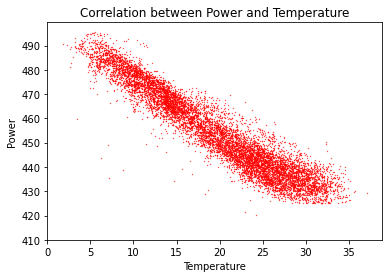

In [136]:
# TODO: Replace <FILL IN> with appropriate code
import numpy as np
import matplotlib.pyplot as plt

data = sqlDF.select('Temperature','Power').collect()

x, y = zip(*data) # split Temperature (x) and Power (y)

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.scatter(x,y,color="red",s=0.1) # scatter plot command
plt.title("Correlation between Power and Temperature") # title
plt.xlabel("Temperature") # xlabel
plt.ylabel("Power") # ylabel
plt.xticks(np.arange(0,40, step=5))# xticks
plt.yticks(np.arange(410,500, step=10)) # yticks

plt.show()

It looks like there is strong linear correlation between Temperature and Power Output.

**ASIDE: A quick physics lesson**: This correlation is to be expected as the second law of thermodynamics puts a fundamental limit on the [thermal efficiency](https://en.wikipedia.org/wiki/Thermal_efficiency) of all heat-based engines. The limiting factors are:
 - The temperature at which the heat enters the engine \\( T_{H} \\)
 - The temperature of the environment into which the engine exhausts its waste heat \\( T_C \\)

Our temperature measurements are the temperature of the environment. From [Carnot's theorem](https://en.wikipedia.org/wiki/Carnot%27s_theorem_%28thermodynamics%29), no heat engine working between these two temperatures can exceed the Carnot Cycle efficiency:
\\[ n_{th} \le 1 - \frac{T_C}{T_H}  \\]

Note that as the environmental temperature increases, the efficiency decreases -- _this is the effect that we see in the above graph._

### Exercise 4(b)

Use SQL to create a scatter plot of Power (PE) as a function of ExhaustVacuum (V).
Name the y-axis "Power" and the x-axis "ExhaustVacuum"

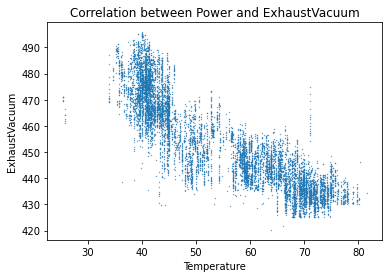

In [137]:
# TODO: Replace <FILL IN> with appropriate code

data = spark.sql("Select V as ExhaustVacuum, PE as Power from power_plant").collect()

x, y = zip(*data) # split ExhaustVacuum (x) and Power (y)

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.scatter(x,y,s=0.1) # scatter plot command
plt.title("Correlation between Power and ExhaustVacuum") # title
plt.xlabel("Temperature") # xlabel
plt.ylabel("ExhaustVacuum") # ylabel

plt.show()

Let's continue exploring the relationships (if any) between the variables and Power Output.

### Exercise 4(c)

Use SQL to create two side-by-side scatter plots:
- Power(PE) as a function of Pressure (AP)
- Power(PE) as a function of Humidity (RH)
Name the y-axis "Power" and the x-axis with the respective label ("Pressure" or "Humidity")

Let's take a look at some of the data.

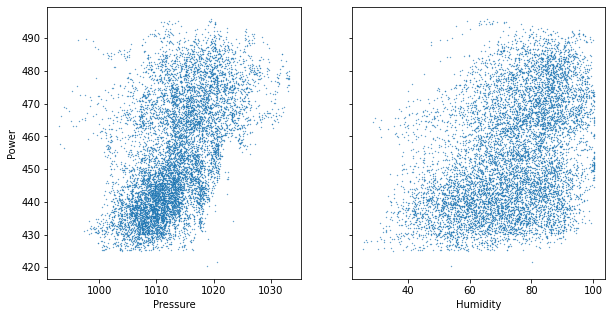

In [138]:
# TODO: Replace <FILL IN> with appropriate code

data = spark.sql("Select AP as Pressure, RH as Humidity, PE as Power from power_plant").collect() # select Pressure, Humidity, and Power in a single query

x1, x2, y = zip(*data) # split Pressure (x1), Humidity (x2) and Power (y)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True) # two-column chart (side-by-side) 

# left chart (axes[0])
axes[0].scatter(x1,y,s=0.1) # scatter plot command
axes[0].set_xlabel("Pressure")# xlabel
axes[0].set_ylabel("Power")# ylabel (you only need to set the ylabel for axes[0])

# left chart (axes[1])
axes[1].scatter(x2,y,s=0.1) # scatter plot command
axes[1].set_xlabel("Humidity") # xlabel

plt.show()

## Part 5: Data Preparation

The next step is to prepare the data for machine learning. Since all of this data is numeric and consistent this is a simple and straightforward task.

The goal is to use machine learning to determine a function that yields the output power as a function of a set of predictor features. The first step in building our ML pipeline is to convert the predictor features from DataFrame columns to Feature Vectors using the [pyspark.ml.feature.VectorAssembler()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html?highlight=assembler#pyspark.ml.feature.VectorAssembler) method.

The `VectorAssembler` is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like logistic regression and decision trees. `VectorAssembler` takes a list of input column names (each is a string) and the name of the output column (as a string).

### Exercise 5(a)

- Read the Spark documentation and useage examples for [VectorAssembler](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html?highlight=assembler#pyspark.ml.feature.VectorAssembler
- Convert the `power_plant` SQL table into a DataFrame named `dataset`
- Set the vectorizer's input columns to a list of the four columns of the input DataFrame: `["AT", "V", "AP", "RH"]`
- Set the vectorizer's output column name to `"features"`

In [139]:
# TODO: Replace <FILL_IN> with the appropriate code
from pyspark.ml.feature import VectorAssembler

datasetDF = df

vectorizer = VectorAssembler()

vectorizer.setInputCols(["AT","V","AP","RH"])
vectorizer.setOutputCol("features")

VectorAssembler_4acf090d7692

In [140]:
# TEST
testmti850.Test.assertEquals(set(vectorizer.getInputCols()), {"AT", "V", "AP", "RH"}, "Incorrect vectorizer input columns")
testmti850.Test.assertEquals(vectorizer.getOutputCol(), "features", "Incorrect vectorizer output column")

1 test passed.
1 test passed.


## Part 6: Data Modeling
Now let's model our data to predict what the power output will be given a set of sensor readings

Our first model will be based on simple linear regression since we saw some linear patterns in our data based on the scatter plots during the exploration stage.

We need a way of evaluating how well our linear regression model predicts power output as a function of input parameters. We can do this by splitting up our initial data set into a _Training Set_ used to train our model and a _Test Set_ used to evaluate the model's performance in giving predictions.

We can use a DataFrame's [randomSplit()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) method to split our dataset. The method takes a list of weights and an optional random seed. The seed is used to initialize the random number generator used by the splitting function.

### Exercise 6(a)

Use the [randomSplit()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) method to divide up `datasetDF` into a trainingSetDF (80% of the input DataFrame) and a testSetDF (20% of the input DataFrame), and for reproducibility, use the seed 1800009193.

Then cache each DataFrame in memory to maximize performance.

In [141]:
# TODO: Replace <FILL_IN> with the appropriate code.
# We'll hold out 20% of our data for testing and leave 80% for training
seed = 1800009193

(split20DF, split80DF) = datasetDF.randomSplit([.20,.80],seed)

# Let's cache these datasets for performance
testSetDF = split20DF.cache()
trainingSetDF = split80DF.cache()

trainingSetDF.show()

+----+-----+-------+-----+------+
|  AT|    V|     AP|   RH|    PE|
+----+-----+-------+-----+------+
|1.81|39.42|1026.92|76.97|490.55|
|2.58|39.42|1028.68|69.03|488.69|
|2.64|39.64|1011.02|85.24|481.29|
|2.71|39.42|1026.66|81.11| 489.3|
| 3.0|39.64| 1011.0|80.14| 485.2|
| 3.2|41.31| 997.67|98.84|489.86|
|3.21|38.44| 1016.9|86.34|491.35|
|3.21|38.44|1017.11|84.86|492.93|
|3.26|41.31| 996.32|100.0|489.38|
|3.31|39.42|1024.05|84.31|487.19|
|3.38|39.64| 1011.0|81.22|488.92|
|3.38|41.31| 998.79|97.76|489.11|
| 3.4|39.64| 1011.1|83.43|459.86|
|3.51|35.47|1017.53|86.56|489.07|
| 3.6|35.19|1018.73| 99.1|488.98|
|3.63|38.44|1016.16|87.38|487.87|
|3.68|39.64|1011.31|84.05|490.02|
|3.69|38.44|1016.74|82.87|490.78|
|3.73|39.42| 1024.4|82.42|488.58|
|3.74|35.19|1018.58|98.84| 490.5|
+----+-----+-------+-----+------+
only showing top 20 rows



In [142]:
# TEST
testmti850.Test.assertEquals(trainingSetDF.count(), 7712, "Incorrect size for training data set")
testmti850.Test.assertEquals(testSetDF.count(), 1856, "Incorrect size for test data set")

1 test passed.
1 test passed.


Next we'll create a Linear Regression Model and use the built in help to identify how to train it. See API details for [Linear Regression](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html?highlight=linearregression#pyspark.ml.regression.LinearRegression) in the ML guide.

### Exercise 6(b)

- Read the documentation and examples for [Linear Regression](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html?highlight=linearregression#pyspark.ml.regression.LinearRegression)
- Run the next cell

In [143]:
# LINEAR REGRESSION MODEL

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml import Pipeline

# Let's initialize our linear regression learner
lr = LinearRegression()

# We use explain params to dump the parameters we can use
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
loss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)
maxBlockSizeInMB: maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0. (default: 0.0)
maxIter: max number of iterations (>= 0). (default: 100)
predic

The cell below is based on the [Spark ML Pipeline API for Linear Regression](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html?highlight=linearregression#pyspark.ml.regression.LinearRegression)

The first step is to set the parameters for the method:
- Set the name of the prediction column to "Predicted_PE"
- Set the name of the label column to "PE"
- Set the maximum number of iterations to 100
- Set the regularization parameter to 0.1

Next, we create the [ML Pipeline](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html?highlight=linearregression#pyspark.ml.Pipeline) and set the stages to the Vectorizer and Linear Regression learner we created earlier.

Finally, we create a model by training on `trainingSetDF`.

### Exercise 6(c)

- Read the [Linear Regression](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html?highlight=linearregression#pyspark.ml.regression.LinearRegression) documentation
- Run the next cell, and be sure you understand what's going on.

In [144]:
# Now we set the parameters for the method
lr.setPredictionCol("Predicted_PE")\
  .setLabelCol("PE")\
  .setMaxIter(100)\
  .setRegParam(0.1)

# We will use the new spark.ml pipeline API. If you have worked with scikit-learn this will be very familiar.
lrPipeline = Pipeline()

lrPipeline.setStages([vectorizer, lr])

# Let's first train on the entire dataset to see what we get
lrModel = lrPipeline.fit(trainingSetDF)

From the Wikipedia article on [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression):
> In statistics, linear regression is an approach for modeling the relationship between a scalar dependent variable \\( y \\) and one or more explanatory variables (or independent variables) denoted \\(X\\). In linear regression, the relationships are modeled using linear predictor functions whose unknown model parameters are estimated from the data. Such models are called linear models.

Linear regression has many practical uses. Most applications fall into one of the following two broad categories:
  - If the goal is prediction, or forecasting, or error reduction, linear regression can be used to fit a predictive model to an observed data set of \\(y\\) and \\(X\\) values. After developing such a model, if an additional value of \\(X\\) is then given without its accompanying value of \\(y\\), the fitted model can be used to make a prediction of the value of \\(y\\).
  - Given a variable \\(y\\) and a number of variables \\( X_1 \\), ..., \\( X_p \\) that may be related to \\(y\\), linear regression analysis can be applied to quantify the strength of the relationship between \\(y\\) and the \\( X_j\\), to assess which \\( X_j \\) may have no relationship with \\(y\\) at all, and to identify which subsets of the \\( X_j \\) contain redundant information about \\(y\\).

We are interested in both uses, as we would like to predict power output as a function of the input variables, and we would like to know which input variables are weakly or strongly correlated with power output.

Since Linear Regression is simply a Line of best fit over the data that minimizes the square of the error, given multiple input dimensions we can express each predictor as a line function of the form:

\\[ y = a + b x_1 + b x_2 + b x_i ... \\]

where \\(a\\) is the intercept and the \\(b\\) are the coefficients.

To express the coefficients of that line we can retrieve the Estimator stage from the PipelineModel and express the weights and the intercept for the function.

### Exercise 6(d)

Run the next cell. Ensure that you understand what's going on.

In [145]:
# The intercept is as follows:
intercept = lrModel.stages[1].intercept

# The coefficents (i.e., weights) are as follows:
weights = lrModel.stages[1].coefficients

# Create a list of the column names (without PE)
featuresNoLabel = [col for col in datasetDF.columns if col != "PE"]

# Merge the weights and labels
coefficents = zip(weights, featuresNoLabel)

# Now let's sort the coefficients from greatest absolute weight most to the least absolute weight
coefficents_sorted = sorted(coefficents, key = lambda tup:abs(tup[0]), reverse=True)

equation = "y = {intercept}".format(intercept=intercept)
variables = []

for x in coefficents_sorted:
    weight = abs(x[0])
    name = x[1]
    symbol = "+" if (x[0] > 0) else "-"
    equation += (" {} ({} * {})".format(symbol, weight, name))

# Finally here is our equation
print("Linear Regression Equation: " + equation)

Linear Regression Equation: y = 434.0183482458498 - (1.9288465830311992 * AT) - (0.2493165946592376 * V) - (0.14587975219954638 * RH) + (0.08140785421512364 * AP)


Recall **Part 4: Visualize Your Data** when we visualized each predictor against Power Output using a Scatter Plot, does the final equation seems logical given those visualizations?

### Exercise 6(e)

Now let's see what our predictions look like given this model. We apply our Linear Regression model to the 20% of the data that we split from the input dataset. The output of the model will be a predicted Power Output column named "Predicted_PE".

- Run the next cell
- Scroll through the resulting table and notice how the values in the Power Output (PE) column compare to the corresponding values in the predicted Power Output (Predicted_PE) column

In [146]:
# Apply our LR model to the test data and predict power output
import pandas as pd

pd.set_option('display.max_rows', None)

predictionsAndLabelsDF = lrModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Predicted_PE")

predictionsAndLabelsDF.toPandas() # convert into a Pandas DataFrame and display 

,AT,V,AP,RH,PE,Predicted_PE
0,2.34,39.42,1028.47,69.68,490.34,493.237422
1,2.80,39.64,1011.01,82.96,482.66,488.936638
2,3.82,35.47,1016.62,84.34,489.04,488.264249
3,3.98,35.47,1017.22,86.53,489.64,487.685002
4,4.23,38.44,1016.46,76.64,489.00,487.843201
5,4.32,35.47,1017.80,88.51,488.03,486.787569
6,4.43,38.91,1019.04,88.17,491.90,485.868291
7,4.65,35.19,1018.23,94.78,489.36,485.341197
8,4.78,42.85,1013.39,93.36,481.47,482.993817
9,4.87,42.85,1012.69,94.72,482.05,482.564839


From a visual inspection of the predictions, we can see that they are close to the actual values.

However, we would like a scientific measure of how well the Linear Regression model is performing in accurately predicting values. To perform this measurement, we can use an evaluation metric such as [Root Mean Squared Error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE) to validate our Linear Regression model.

RSME is defined as follows: \\( RMSE = \sqrt{\frac{\sum_{i = 1}^{n} (x_i - y_i)^2}{n}}\\) where \\(y_i\\) is the observed value and \\(x_i\\) is the predicted value

RMSE is a frequently used measure of the differences between values predicted by a model or an estimator and the values actually observed. The lower the RMSE, the better our model.

Spark ML Pipeline provides several regression analysis metrics, including [RegressionEvaluator()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator).

After we create an instance of [RegressionEvaluator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator), we set the label column name to "PE" and set the prediction column name to "Predicted_PE". We then invoke the evaluator on the predictions.

### Exercise 6(f)

Run the next cell and ensure that you understand what's going on.

In [147]:
# Now let's compute an evaluation metric for our test dataset
from pyspark.ml.evaluation import RegressionEvaluator

# Create an RMSE evaluator using the label and predicted columns
regEval = RegressionEvaluator(predictionCol="Predicted_PE", labelCol="PE", metricName="rmse")

# Run the evaluator on the DataFrame
rmse = regEval.evaluate(predictionsAndLabelsDF)

print("Root Mean Squared Error: %.2f" % rmse)

Root Mean Squared Error: 4.43


Another useful statistical evaluation metric is the coefficient of determination, denoted \\(R^2\\) or \\(r^2\\) and pronounced "R squared". It is a number that indicates the proportion of the variance in the dependent variable that is predictable from the independent variable and it provides a measure of how well observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model. The coefficient of determination ranges from 0 to 1 (closer to 1), and the higher the value, the better our model.

To compute \\(r^2\\), we invoke the evaluator with  `regEval.metricName: "r2"`

### Exercise 6(g)

Run the next cell and ensure that you understand what's going on.

In [148]:
# Now let's compute another evaluation metric for our test dataset
r2 = regEval.evaluate(predictionsAndLabelsDF, {regEval.metricName: "r2"})

print("r2: {0:.2f}".format(r2))

r2: 0.93


Generally, assuming a Gaussian distribution of errors, a good model will have 68% of predictions within 1 RMSE and 95% within 2 RMSE of the actual value (see http://statweb.stanford.edu/~susan/courses/s60/split/node60.html).

Let's examine the predictions and see if a RMSE of 4.59 meets this criteria.

We create a new DataFrame using [selectExpr()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.sql.html?highlight=selectexpr#pyspark.sql.DataFrame.selectExpr) to project a set of SQL expressions, and register the DataFrame as a SQL table using [createOrReplaceTempView()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.sql.html?highlight=createorreplacetempview#pyspark.sql.DataFrame.createOrReplaceTempView).

### Exercise 6(h)

Run the next cell and ensure that you understand what's going on.

In [149]:
# Calculate the residual error and divide it by the RMSE
predictionsAndLabelsDF.selectExpr("PE", "Predicted_PE",
                                  "PE - Predicted_PE Residual_Error",
                                  "(PE - Predicted_PE) / {} Within_RSME".format(rmse)).createOrReplaceTempView("Power_Plant_RMSE_Evaluation")



We can use SQL to explore the `Power_Plant_RMSE_Evaluation` table. First let's look at at the table using a SQL SELECT statement.

### Exercise 6(i)

Run the next cell and ensure that you understand what's going on.

In [150]:
rmseDF = spark.sql("SELECT * from Power_Plant_RMSE_Evaluation")
rmseDF.show()

+------+------------------+--------------------+--------------------+
|    PE|      Predicted_PE|      Residual_Error|         Within_RSME|
+------+------------------+--------------------+--------------------+
|490.34|493.23742177145346| -2.8974217714534802| -0.6545286058917738|
|482.66|488.93663844862806|  -6.276638448628034|  -1.417894851879411|
|489.04| 488.2642491377767|  0.7757508622233331| 0.17524239493640179|
|489.64| 487.6850017397038|   1.954998260296179|  0.4416348004421164|
| 489.0|487.84320058785806|   1.156799412141936| 0.26132139752158323|
|488.03|486.78756854756284|  1.2424314524371312| 0.28066570579809824|
| 491.9| 485.8682911927762|   6.031708807223765|   1.362565159009226|
|489.36|485.34119715268844|   4.018802847311576|  0.9078489886838934|
|481.47| 482.9938172155268| -1.5238172155267762|  -0.344230849488058|
|482.05|482.56483906211207| -0.5148390621120598|-0.11630232674540568|
|494.75|487.00024243767604|   7.749757562323964|  1.7506729821811777|
|482.98|483.34675257

Now we can display the RMSE as a Histogram.

### Exercise 6(j)
Display the histogram of RMSE using the method [DataFrame.plot.hist()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.hist.html?highlight=hist#pandas.DataFrame.plot.hist). This can be done in two steps:

- Select the 'Within_RSME' column from rmseDF and convert it to a Pandas DataFrame
- Use the method [DataFrame.plot.hist()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.hist.html?highlight=hist#pandas.DataFrame.plot.hist) to plot a histogram with 100 bins (bars).

**PS.**: Notice that the histogram clearly shows that the RMSE is centered around 0 with the vast majority of the error within 2 RMSEs.

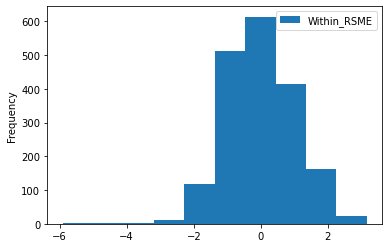

In [151]:
# TODO: Replace <FILL IN> with appropriate code

rmseDF_pd = rmseDF.select("Within_RSME").toPandas()

rmseDF_pd.plot.hist() # plot

plt.show()

Using a complex SQL SELECT statement, we can count the number of predictions within + or - 1.0 and + or - 2.0 and then display the results as a pie chart.

### Exercise 6(k)

Run the following cell

In [152]:
complex_query = \
"""
SELECT case when Within_RSME <= 1.0 AND Within_RSME >= -1.0 then 1
            when Within_RSME <= 2.0 AND Within_RSME >= -2.0 then 2 else 3
       end RSME_Multiple, COUNT(*) AS count
FROM Power_Plant_RMSE_Evaluation
GROUP BY case when Within_RSME <= 1.0 AND Within_RSME >= -1.0 then 1 when Within_RSME <= 2.0 AND Within_RSME >= -2.0 then 2 else 3 end
"""

wrmseDF = spark.sql(complex_query)
wrmseDF.show()

+-------------+-----+
|RSME_Multiple|count|
+-------------+-----+
|            1| 1267|
|            3|   77|
|            2|  512|
+-------------+-----+



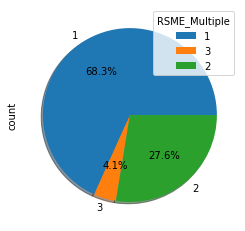

In [153]:
wrmseDF_pd = wrmseDF.toPandas().set_index('RSME_Multiple')

ax = wrmseDF_pd.plot.pie(y='count', autopct='%1.1f%%',
        shadow=True)

ax.legend().set_title('RSME_Multiple')

From the pie chart, we can see that 68.3% of our test data predictions are within 1 RMSE of the actual values, and 95.9% (68.3% + 27.6%) of our test data predictions are within 2 RMSE. So the model is pretty decent. Let's see if we can tune the model to improve it further.

## Part 7: Tuning and Evaluation

Now that we have a model with all of the data let's try to make a better model by tuning over several parameters. The process of tuning a model is known as [Model Selection](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#module-pyspark.ml.tuning) or [Hyperparameter Tuning](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#module-pyspark.ml.tuning), and Spark ML Pipeline makes the tuning process very simple and easy.

An important task in ML is model selection, or using data to find the best model or parameters for a given task. This is also called tuning. Tuning may be done for individual Estimators such as [LinearRegression](https://spark.apache.org/docs/3.0.0/ml-classification-regression.html#linear-regression), or for entire Pipelines which include multiple algorithms, featurization, and other steps. Users can tune an entire Pipeline at once, rather than tuning each element in the Pipeline separately.

Spark ML Pipeline supports model selection using tools such as [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator), which requires the following items:
  - [Estimator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.Estimator): algorithm or Pipeline to tune
  - [Set of ParamMaps](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder): parameters to choose from, sometimes called a _parameter grid_ to search over
  - [Evaluator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.Evaluator): metric to measure how well a fitted Model does on held-out test data

At a high level, model selection tools such as [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) work as follows:
  - They split the input data into separate training and test datasets.
  - For each (training, test) pair, they iterate through the set of ParamMaps:
    - For each [ParamMap](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder), they fit the [Estimator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.Estimator) using those parameters, get the fitted Model, and evaluate the Model's performance using the [Evaluator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.Evaluator).
  - They select the Model produced by the best-performing set of parameters.

The [Evaluator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.Evaluator) can be a [RegressionEvaluator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator) for regression problems. To help construct the parameter grid, users can use the [ParamGridBuilder](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder) utility.

Note that cross-validation over a grid of parameters is expensive. For example, in the next cell, the parameter grid has 10 values for [lr.regParam](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression.regParam), and [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) uses 3 folds. This multiplies out to (10 x 3) = 30 different models being trained. In realistic settings, it can be common to try many more parameters (e.g., multiple values for multiple parameters) and use more folds (_k_ = 3 and _k_ = 10 are common). In other words, using [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) can be very expensive. However, it is also a well-established method for choosing parameters which is more statistically sound than heuristic hand-tuning.

We perform the following steps:
  - Create a [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) using the Pipeline and [RegressionEvaluator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator) that we created earlier, and set the number of folds to 3
  - Create a list of 10 regularization parameters
  - Use [ParamGridBuilder](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder) to build a parameter grid with the regularization parameters and add the grid to the [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator)
  - Run the [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) to find the parameters that yield the best model (i.e., lowest RMSE) and return the best model.

### Exercise 7(a)

Run the next cell. _Note that it will take some time to run the [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) as it will run almost 200 Spark jobs_

In [154]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# We can reuse the RegressionEvaluator, regEval, to judge the model based on the best Root Mean Squared Error
# Let's create our CrossValidator with 3 fold cross validation
crossval = CrossValidator(estimator=lrPipeline, evaluator=regEval, numFolds=3)

# Let's tune over our regularization parameter from 0.01 to 0.10
regParam = [x / 100.0 for x in range(1, 11)]

# We'll create a paramter grid using the ParamGridBuilder, and add the grid to the CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, regParam)
             .build())

crossval.setEstimatorParamMaps(paramGrid)

# Now let's find and return the best model
cvModel = crossval.fit(trainingSetDF).bestModel

Now that we have tuned our Linear Regression model, let's see what the new RMSE and \\(r^2\\) values are versus our intial model.

### Exercise 7(b)

Complete and run the next cell.

In [155]:
# TODO: Replace <FILL_IN> with the appropriate code.

# Now let's use cvModel to compute an evaluation metric for our test dataset: testSetDF
predictionsAndLabelsDF = cvModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Predicted_PE")

# Run the previously created RMSE evaluator, regEval, on the predictionsAndLabelsDF DataFrame
rmseNew = regEval.evaluate(predictionsAndLabelsDF)

# Now let's compute the r2 evaluation metric for our test dataset
r2New = regEval.evaluate(predictionsAndLabelsDF, {regEval.metricName: "r2"})

print("Original Root Mean Squared Error: {0:2.2f}".format(rmse))
print("New Root Mean Squared Error: {0:2.2f}".format(rmseNew))
print("Old r2: {0:2.2f}".format(r2))
print("New r2: {0:2.2f}".format(r2New))

Original Root Mean Squared Error: 4.43
New Root Mean Squared Error: 4.43
Old r2: 0.93
New r2: 0.93


In [156]:
# TEST
testmti850.Test.assertEquals(round(rmse, 2), 4.43, "Incorrect value for rmse")
testmti850.Test.assertEquals(round(rmseNew, 2), 4.43, "Incorrect value for rmseNew")
testmti850.Test.assertEquals(round(r2, 2), 0.93, "Incorrect value for r2")
testmti850.Test.assertEquals(round(r2New, 2), 0.93, "Incorrect value for r2New")

1 test passed.
1 test passed.
1 test passed.
1 test passed.


So our initial untuned and tuned linear regression models are statistically identical. Let's look at the regularization parameter that the [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html?highlight=crossvalidator#pyspark.ml.tuning.CrossValidator) has selected.

Recall that the orginal regularization parameter we used was 0.01.

**NOTE**: The ML Python API currently doesn't provide a way to query the regularization parameter, so we cheat, by "reaching through" to the JVM version of the API.

In [157]:
print("Regularization parameter of the best model: {0:.5f}".format(cvModel.stages[-1]._java_obj.parent().getRegParam()))

Regularization parameter of the best model: 0.01000


Given that the only linearly correlated variable is Temperature, it makes sense try another Machine Learning method such as [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree_learning) to handle non-linear data and see if we can improve our model.

[Decision Tree Learning](https://en.wikipedia.org/wiki/Decision_tree_learning) uses a [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree) as a predictive model which maps observations about an item to conclusions about the item's target value. It is one of the predictive modelling approaches used in statistics, data mining and machine learning. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.

Spark ML Pipeline provides [DecisionTreeRegressor()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor) as an implementation of [Decision Tree Learning](https://en.wikipedia.org/wiki/Decision_tree_learning).

The cell below is based on the [Spark ML Pipeline API for Decision Tree Regressor](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor).

### Exercise 7(c)

- Read the [Decision Tree Regressor](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor) documentation
- In the next cell, create a [DecisionTreeRegressor()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor)

- The next step is to set the parameters for the method (we do this for you):
  - Set the name of the prediction column to "Predicted_PE"
  - Set the name of the features column to "features"
  - Set the maximum number of bins to 100

- Create the [ML Pipeline](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.Pipeline) and set the stages to the Vectorizer we created earlier and [DecisionTreeRegressor()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor) learner we just created.

In [158]:
# TODO: Replace <FILL_IN> with the appropriate code.
from pyspark.ml.regression import DecisionTreeRegressor

# Create a DecisionTreeRegressor
dt = DecisionTreeRegressor()

dt.setLabelCol("PE")\
  .setPredictionCol("Predicted_PE")\
  .setFeaturesCol("features")\
  .setMaxBins(100)

# Create a Pipeline
dtPipeline = Pipeline()

# Set the stages of the Pipeline
dtPipeline.setStages([vectorizer,dt])

Pipeline_8ca81f0fee5b

In [159]:
# TEST

testmti850.Test.assertEqualsHashed(str(dtPipeline.getStages()[0].__class__.__name__), '4617be70bcf475326c0b07400b97b13457cc4949', "Incorrect pipeline stage 0")
testmti850.Test.assertEqualsHashed(str(dtPipeline.getStages()[1].__class__.__name__), '46b18f257cf2f778d0d3b6e30ccc7b3398d7846a', "Incorrect pipeline stage 1")

1 test passed.
1 test passed.


Instead of guessing what parameters to use, we will use [Model Selection](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#module-pyspark.ml.tuning) or [Hyperparameter Tuning](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#module-pyspark.ml.tuning) to create the best model.

We can reuse the exiting [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) by replacing the Estimator with our new `dtPipeline` (the number of folds remains 3).

### Exercise 7(d)

- Use [ParamGridBuilder](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder) to build a parameter grid with the parameter `dt.maxDepth` and a list of the values 2 and 3, and add the grid to the [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator)
- Run the [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) to find the parameters that yield the best model (i.e. lowest RMSE) and return the best model.

_Note that it will take some time to run the [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) as it will run almost 50 Spark jobs_

In [160]:
# TODO: Replace <FILL_IN> with the appropriate code.

# Let's just reuse our CrossValidator with the new dtPipeline,  RegressionEvaluator regEval, and 3 fold cross validation
crossval.setEstimator(dtPipeline).setEvaluator(regEval).setNumFolds(3)

# Let's tune over our dt.maxDepth parameter on the values 2 and 3, create a paramter grid using the ParamGridBuilder
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2,3])
             .build())

# Add the grid to the CrossValidator
crossval.setEstimatorParamMaps(paramGrid)

# Now let's find and return the best model
dtModel = crossval.fit(trainingSetDF).bestModel

In [161]:
# TEST

testmti850.Test.assertEqualsHashed(str(dtModel.stages[0].__class__.__name__), '4617be70bcf475326c0b07400b97b13457cc4949', "Incorrect pipeline stage 0")
testmti850.Test.assertEqualsHashed(str(dtModel.stages[1].__class__.__name__), 'a2bf7b0c1a0fb9ad35650d0478ad51a9b880befa', "Incorrect pipeline stage 1")

1 test passed.
1 test passed.


### Exercise 7(e)

Now let's see how our tuned DecisionTreeRegressor model's RMSE and \\(r^2\\) values compare to our tuned LinearRegression model.

Complete and run the next cell.

In [162]:
# TODO: Replace <FILL_IN> with the appropriate code.

# Now let's use dtModel to compute an evaluation metric for our test dataset: testSetDF
predictionsAndLabelsDF = dtModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Predicted_PE")

# Run the previously created RMSE evaluator, regEval, on the predictionsAndLabelsDF DataFrame
rmseDT = regEval.evaluate(predictionsAndLabelsDF)

# Now let's compute the r2 evaluation metric for our test dataset
r2DT = regEval.evaluate(predictionsAndLabelsDF, {regEval.metricName: "r2"})

print("Linear Regression Root Mean Squared Error: {0:.2f}".format(rmseNew))
print("Decision Tree Regressor Root Mean Squared Error: {0:.2f}".format(rmseDT))
print("Linear Regression r2: {0:.2f}".format(r2New))
print("Decision Tree Regressor r2: {0:.2f}".format(r2DT))

Linear Regression Root Mean Squared Error: 4.43
Decision Tree Regressor Root Mean Squared Error: 5.11
Linear Regression r2: 0.93
Decision Tree Regressor r2: 0.91


In [163]:
# TEST
testmti850.Test.assertEquals(round(rmseDT, 2), 4.35, "Incorrect value for rmseDT")
testmti850.Test.assertEquals(round(r2DT, 2), 0.93, "Incorrect value for r2DT")

1 test failed. Incorrect value for rmseDT
1 test failed. Incorrect value for r2DT


The line below will pull the Decision Tree model from the Pipeline and display it as an if-then-else string. Again, we have to "reach through" to the JVM API to make this one work.

**ToDo**: Run the next cell

In [164]:
print(dtModel.stages[-1]._java_obj.toDebugString())

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_a916cd7e4784, depth=3, numNodes=15, numFeatures=4
  If (feature 0 <= 18.595)
   If (feature 0 <= 11.885000000000002)
    If (feature 0 <= 8.575)
     Predict: 483.994943457189
    Else (feature 0 > 8.575)
     Predict: 476.04374262101527
   Else (feature 0 > 11.885000000000002)
    If (feature 0 <= 15.475000000000001)
     Predict: 467.5564649956784
    Else (feature 0 > 15.475000000000001)
     Predict: 459.5010376134889
  Else (feature 0 > 18.595)
   If (feature 1 <= 66.21000000000001)
    If (feature 0 <= 22.055)
     Predict: 452.01076923076914
    Else (feature 0 > 22.055)
     Predict: 443.46937926330156
   Else (feature 1 > 66.21000000000001)
    If (feature 0 <= 25.325)
     Predict: 440.73731707317074
    Else (feature 0 > 25.325)
     Predict: 433.86131215469624



So our DecisionTree has slightly better RMSE than our LinearRegression model (LR: 4.43 vs DT: 4.35). Maybe we can try an [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning) method such as [Gradient-Boosted Decision Trees](https://en.wikipedia.org/wiki/Gradient_boosting) to see if we can strengthen our model by using an ensemble of weaker trees with weighting to reduce the error in our model.

[Random forests](https://en.wikipedia.org/wiki/Random_forest) or random decision tree forests are an ensemble learning method for regression that operate by constructing a multitude of decision trees at training time and outputting the class that is the mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

Spark ML Pipeline provides [RandomForestRegressor()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor) as an implementation of [Random forests](https://en.wikipedia.org/wiki/Random_forest).

The cell below is based on the [Spark ML Pipeline API for Random Forest Regressor](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor).

### Exercise 7(f)

- Read the [Random Forest Regressor](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor) documentation
- In the next cell, create a [RandomForestRegressor()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor)
- The next step is to set the parameters for the method (we do this for you):
  - Set the name of the prediction column to "Predicted_PE"
  - Set the name of the features column to "features"
  - Set the random number generator seed to 100088121
  - Set the maximum depth to 8
  - Set the number of trees to 30
- Create the [ML Pipeline](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.Pipeline) and set the stages to the Vectorizer we created earlier and [RandomForestRegressor()](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor) learner we just created.

In [165]:
# TODO: Replace <FILL_IN> with the appropriate code.

from pyspark.ml.regression import RandomForestRegressor

# Create a RandomForestRegressor
rf = RandomForestRegressor()

rf.setLabelCol("PE")\
  .setPredictionCol("Predicted_PE")\
  .setFeaturesCol("features")\
.setMaxDepth(8)\
.setNumTrees(30)\
.setSeed(100088121)

# Create a Pipeline
rfPipeline = Pipeline()

# Set the stages of the Pipeline
rfPipeline.setStages([vectorizer,rf])

Pipeline_58c46a124399

In [166]:
# TEST
testmti850.Test.assertEqualsHashed(rfPipeline.getStages()[0].__class__.__name__, '4617be70bcf475326c0b07400b97b13457cc4949', "Stage 0 of pipeline is not correct")
testmti850.Test.assertEqualsHashed(rfPipeline.getStages()[1].__class__.__name__, 'ecdcce2d075f00c97a6d2a2b8b1f66de322e57d2', "Stage 1 of pipeline is not correct")

1 test passed.
1 test passed.


As with Decision Trees, instead guessing what parameters to use, we will use [Model Selection](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#module-pyspark.ml.tuning) or [Hyperparameter Tuning](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#module-pyspark.ml.tuning) to create the best model.

We can reuse the existing [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) by replacing the Estimator with our new `rfPipeline` (the number of folds remains 3).

### Exercise 7(g)

- Use [ParamGridBuilder](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder) to build a parameter grid with the parameter `rf.maxBins` and a list of the values 50 and 100, and add the grid to the [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator)
- Run the [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) to find the parameters that yield the best model (i.e., lowest RMSE) and return the best model.

_Note that it will take some time to run the [CrossValidator](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) as it will run almost 100 Spark jobs, and each job takes longer to run than the prior CrossValidator runs._

In [167]:
# TODO: Replace <FILL_IN> with the appropriate code.
# Let's just reuse our CrossValidator with the new rfPipeline,  RegressionEvaluator regEval, and 3 fold cross validation
crossval.setEstimator(rfPipeline).setEvaluator(regEval).setNumFolds(3)

# Let's tune over our rf.maxBins parameter on the values 50 and 100, create a parameter grid using the ParamGridBuilder
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxBins, [50,100])
             .build())

# Add the grid to the CrossValidator
crossval.setEstimatorParamMaps(paramGrid)
# Now let's find and return the best model
rfModel = crossval.fit(trainingSetDF).bestModel

In [168]:
# TEST
testmti850.Test.assertEqualsHashed(rfModel.stages[0].__class__, 'f0c3b910468d87808e019409e7ae5e587d6aca3d', 'rfModel has incorrect stage 0')
testmti850.Test.assertEqualsHashed(rfModel.stages[1].__class__, '0ed43512ea7e35ebeebeed3ddac0186248999a87', 'rfModel has incorrect stage 1')

1 test passed.
1 test passed.


### Exercise 7(h)

Now let's see how our tuned RandomForestRegressor model's RMSE and \\(r^2\\) values compare to our tuned `LinearRegression` and tuned `DecisionTreeRegressor` models.

Complete and run the next cell.

In [169]:
# TODO: Replace <FILL_IN> with the appropriate code.

# Now let's use rfModel to compute an evaluation metric for our test dataset: testSetDF
predictionsAndLabelsDF = rfModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Predicted_PE")

# Run the previously created RMSE evaluator, regEval, on the predictionsAndLabelsDF DataFrame
rmseRF = regEval.evaluate(predictionsAndLabelsDF)

# Now let's compute the r2 evaluation metric for our test dataset
r2RF = regEval.evaluate(predictionsAndLabelsDF, {regEval.metricName: "r2"})

print("Linear Regression Root Mean Squared Error: {0:.2f}".format(rmseNew))
print("Decision Tree Regressor Root Mean Squared Error: {0:.2f}".format(rmseDT))
print("Random Forest Regressor Root Mean Squared Error: {0:.2f}".format(rmseRF))
print("Linear Regression r2: {0:.2f}".format(r2New))
print("Decision Tree Regressor r2: {0:.2f}".format(r2DT))
print("Random Forest Regressor r2: {0:.2f}".format(r2RF))

Linear Regression Root Mean Squared Error: 4.43
Decision Tree Regressor Root Mean Squared Error: 5.11
Random Forest Regressor Root Mean Squared Error: 3.61
Linear Regression r2: 0.93
Decision Tree Regressor r2: 0.91
Random Forest Regressor r2: 0.95


In [170]:
# TEST
testmti850.Test.assertEquals(round(rmseRF, 2), 3.61, "Incorrect value for rmseRF")
testmti850.Test.assertEquals(round(r2RF, 2), 0.95, "Incorrect value for r2RF")

1 test passed.
1 test passed.


Note that the `r2` values are quite close for all three. However, the RMSE for the Random Forest model is better.

The line below will pull the Random Forest model from the Pipeline and display it as an if-then-else string.

**ToDo**: Run the next cell

In [171]:
print(rfModel.stages[-1]._java_obj.toDebugString())

RandomForestRegressionModel: uid=RandomForestRegressor_4a80ae430b65, numTrees=30, numFeatures=4
  Tree 0 (weight 1.0):
    If (feature 2 <= 1014.045)
     If (feature 1 <= 46.345)
      If (feature 3 <= 78.015)
       If (feature 0 <= 16.395)
        If (feature 0 <= 11.335)
         If (feature 0 <= 8.205)
          If (feature 2 <= 1005.345)
           If (feature 0 <= 6.395)
            Predict: 484.5145454545455
           Else (feature 0 > 6.395)
            Predict: 483.8600000000001
          Else (feature 2 > 1005.345)
           If (feature 1 <= 38.754999999999995)
            Predict: 484.81
           Else (feature 1 > 38.754999999999995)
            Predict: 492.97
         Else (feature 0 > 8.205)
          If (feature 2 <= 1012.495)
           If (feature 3 <= 67.985)
            Predict: 476.3541666666667
           Else (feature 3 > 67.985)
            Predict: 479.5776923076923
          Else (feature 2 > 1012.495)
           If (feature 3 <= 73.67500000000001)
       

## End of the assignment